In [1]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import h5netcdf

In [2]:
auth = earthaccess.login(persist=True)

In [3]:
results = earthaccess.search_datasets(instrument="oci")

In [4]:
# for item in results:
#     summary = item.summary()
#     print(summary["short-name"])

In [5]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable
    Args:
        ds: a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    ds = ds.sel(lat=slice(bbox[1], bbox[3]), lon=slice(bbox[0], bbox[2]))
    return ds

In [6]:
tspan = ("2024-08-15", "2025-01-15")
bbox = (-82.85257, 23.847017, -81.68223, 28.215572)
# clouds = (0, 50)

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS",
    temporal=tspan,
    granule_name="*DAY.*.4km.*"
)
len(results)

149

In [8]:
path_files = earthaccess.open(results)
dataset = xr.open_mfdataset(
    path_files, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset

QUEUEING TASKS | :   0%|          | 0/149 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/149 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/149 [00:00<?, ?it/s]

<xarray.Dataset> Size: 117kB
Dimensions:     (date: 149, lat: 0, lon: 28, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 0B 
  * lon         (lon) float32 112B -82.81 -82.77 -82.73 ... -81.77 -81.73 -81.69
  * date        (date) datetime64[ns] 1kB 2024-08-14T23:43:18 ... 2025-01-15T...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (date, lat, lon, wavelength) float32 0B dask.array<chunksize=(1, 0, 28, 8), meta=np.ndarray>
    palette     (date, rgb, eightbitcolor) uint8 114kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240815.L3m.DAY.RRS.V3_0.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3260757
    data_minimum:                      -0.0100000035
    data_maximum:                      0.07017449

In [9]:
rrs = dataset["Rrs"]
rrs

<xarray.DataArray 'Rrs' (date: 149, lat: 0, lon: 28, wavelength: 172)> Size: 0B
dask.array<concatenate, shape=(149, 0, 28, 172), dtype=float32, chunksize=(1, 0, 28, 8), chunktype=numpy.ndarray>
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 0B 
  * lon         (lon) float32 112B -82.81 -82.77 -82.73 ... -81.77 -81.73 -81.69
  * date        (date) datetime64[ns] 1kB 2024-08-14T23:43:18 ... 2025-01-15T...
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000
    display_scale:  linear
    display_min:    0.0
    display_max:    0.025

In [21]:
dataset = xr.open_dataset(paths[0], group="navigation_data")
dataset = dataset.set_coords(("longitude", "latitude"))
# dataset = dataset.rename({"pixel_control_points": "pixels_per_line"})
dataset = xr.merge((rrs, dataset.coords))
dataset

<xarray.Dataset> Size: 2GB
Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272, wavelength_3d: 172)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 9MB ...
    latitude   (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    Rrs        (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000

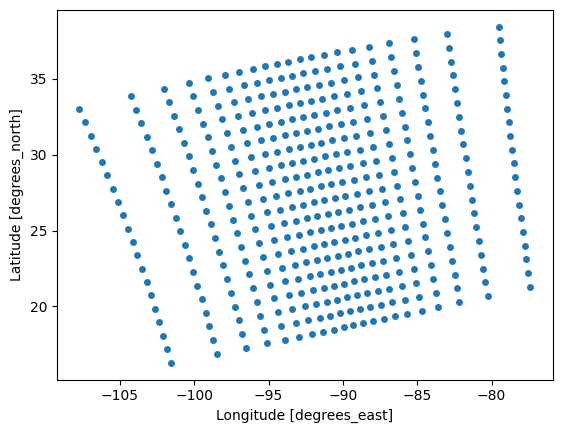

In [22]:
plot = dataset.sel(
    {
        "number_of_lines": slice(None, None, 1720 // 20),
        "pixels_per_line": slice(None, None, 1272 // 20),
    },
).plot.scatter(x="longitude", y="latitude")

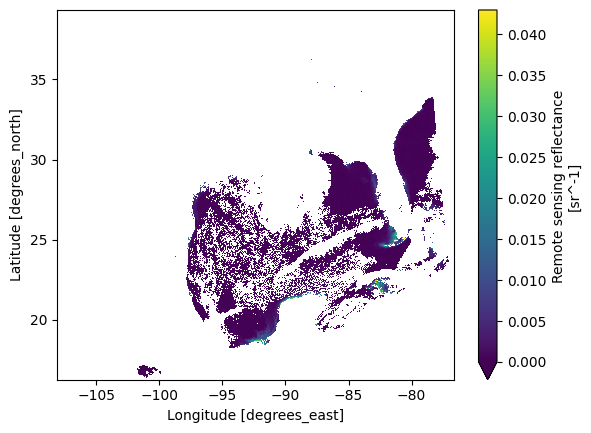

In [23]:
rrs = dataset["Rrs"].sel({'wavelength_3d':100})
plot = rrs.plot(x="longitude", y="latitude", cmap="viridis", vmin=0)

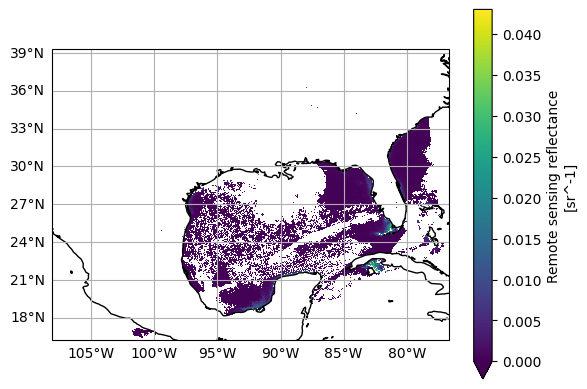

In [24]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = rrs.plot(x="longitude", y="latitude", cmap="viridis", vmin=0, ax=ax)

In [25]:
rrs_box = rrs.where(
    (
        (dataset["latitude"] > bbox[1])
        & (dataset["latitude"] < bbox[3])
        & (dataset["longitude"] > bbox[0])
        & (dataset["longitude"] < bbox[2])
    ),
    drop=True,
)

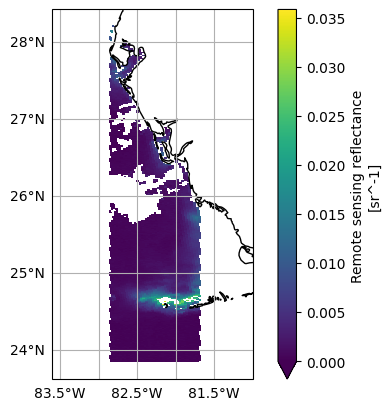

In [26]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = rrs_box.plot(x="longitude", y="latitude", cmap="viridis", vmin=0, ax=ax)

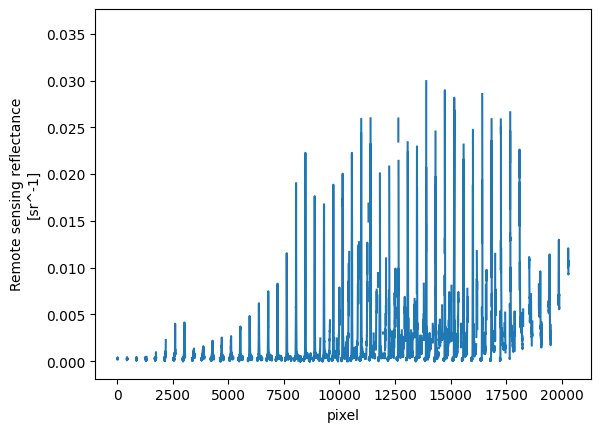

In [28]:
rrs_stack = rrs_box.stack(
    {"pixel": ["number_of_lines", "pixels_per_line"]}, create_index=False,
)
plot = rrs_stack.plot.line(hue="pixel")

In [29]:
tspan = ("2024-08-15", "2025-01-15")
bbox = (-82.85257, 25.847017, -81.68223, 28.215572) # (-76.75, 36.97, -75.74, 39.01) #wsen
clouds = (0, 100)

In [34]:
# earthaccess.search_data(short_name="PACE_OCI_L3B_RRS")

In [30]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3B_RRS",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)
len(results)

0

In [31]:
results[0]

IndexError: list index out of range

In [8]:
paths = earthaccess.open(results) # streaming data

QUEUEING TASKS | :   0%|          | 0/181 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/181 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/181 [00:00<?, ?it/s]

In [9]:
dataset = xr.open_dataset(paths[0])
dataset

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/45)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20240815T173435.L2.OC_AOP.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data17/sdpsoper/vdc/vpu16/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -58.436867
    geospatial_lon_min:                -90.84075
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9751089811325073

In [10]:
datatree = xr.open_datatree(paths[0])
dataset = xr.merge(datatree.to_dict().values())

In [11]:
datatree

<xarray.DataTree>
Group: /
│   Attributes: (12/45)
│       title:                             OCI Level-2 Data AOP
│       product_name:                      PACE_OCI.20240815T173435.L2.OC_AOP.V3_...
│       processing_version:                3.0
│       history:                           l2gen par=/data17/sdpsoper/vdc/vpu16/w...
│       instrument:                        OCI
│       platform:                          PACE
│       ...                                ...
│       geospatial_lon_max:                -58.436867
│       geospatial_lon_min:                -90.84075
│       startDirection:                    Ascending
│       endDirection:                      Ascending
│       day_night_flag:                    Day
│       earth_sun_distance_correction:     0.9751089811325073
├── Group: /sensor_band_parameters
│       Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
│                           wavelength_3d: 172)
│       Coordinates:
│         * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
│       Dimensions without coordinates: number_of_bands, number_of_reflective_bands
│       Data variables:
│           wavelength     (number_of_bands) float64 2kB ...
│           vcal_gain      (number_of_reflective_bands) float32 1kB ...
│           vcal_offset    (number_of_reflective_bands) float32 1kB ...
│           F0             (number_of_reflective_bands) float32 1kB ...
│           aw             (number_of_reflective_bands) float32 1kB ...
│           bbw            (number_of_reflective_bands) float32 1kB ...
│           k_oz           (number_of_reflective_bands) float32 1kB ...
│           k_no2          (number_of_reflective_bands) float32 1kB ...
│           Tau_r          (number_of_reflective_bands) float32 1kB ...
├── Group: /scan_line_attributes
│       Dimensions:  (number_of_lines: 1710)
│       Dimensions without coordinates: number_of_lines
│       Data variables: (12/13)
│           year     (number_of_lines) float64 14kB ...
│           day      (number_of_lines) timedelta64[ns] 14kB ...
│           msec     (number_of_lines) timedelta64[ns] 14kB ...
│           time     (number_of_lines) datetime64[ns] 14kB ...
│           detnum   (number_of_lines) float32 7kB ...
│           mside    (number_of_lines) float32 7kB ...
│           ...       ...
│           clon     (number_of_lines) float32 7kB ...
│           elon     (number_of_lines) float32 7kB ...
│           slat     (number_of_lines) float32 7kB ...
│           clat     (number_of_lines) float32 7kB ...
│           elat     (number_of_lines) float32 7kB ...
│           csol_z   (number_of_lines) float32 7kB ...
├── Group: /geophysical_data
│       Dimensions:   (number_of_lines: 1710, pixels_per_line: 1272, wavelength_3d: 172)
│       Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
│       Data variables:
│           Rrs       (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
│           Rrs_unc   (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
│           aot_865   (number_of_lines, pixels_per_line) float32 9MB ...
│           angstrom  (number_of_lines, pixels_per_line) float32 9MB ...
│           avw       (number_of_lines, pixels_per_line) float32 9MB ...
│           nflh      (number_of_lines, pixels_per_line) float32 9MB ...
│           l2_flags  (number_of_lines, pixels_per_line) int32 9MB ...
├── Group: /navigation_data
│       Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           longitude  (number_of_lines, pixels_per_line) float32 9MB ...
│           latitude   (number_of_lines, pixels_per_line) float32 9MB ...
│           tilt       (number_of_lines) float32 7kB ...
│       Attributes:
│           gringpointlongitude:  [-82.73921  -58.436867 -61.0372   -61.238914 -90.84...
│           gringpointlati

In [12]:
dataset = dataset.set_coords(("longitude", "latitude"))

In [13]:
dataset = dataset.where(
    (dataset["longitude"] >= bbox[0]) & (dataset["longitude"] <= bbox[2]) &
    (dataset["latitude"] >= bbox[1]) & (dataset["latitude"] <= bbox[3]),
    drop=True
)

In [14]:
rrs_rgb = dataset["Rrs"].sel({"wavelength_3d":[709, 650, 470]})

In [31]:
ndci

<xarray.DataArray 'Rrs' (number_of_lines: 234, pixels_per_line: 61,
                         wavelength_3d: 0)> Size: 0B
array([], shape=(234, 61, 0), dtype=float32)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 0B 
    longitude      (number_of_lines, pixels_per_line) float32 57kB -82.77 ......
    latitude       (number_of_lines, pixels_per_line) float32 57kB 25.62 ... ...
Dimensions without coordinates: number_of_lines, pixels_per_line

In [ ]:
rrs_rgb

In [29]:
ndci = (dataset["Rrs"].sel({"wavelength_3d": [709]}) - dataset["Rrs"].sel({"wavelength_3d": [665]}))/(dataset["Rrs"].sel({"wavelength_3d": [709]}) + dataset["Rrs"].sel({"wavelength_3d": [665]}))

In [37]:
def pcolormesh(rgb):
    fig = plt.figure()
    axes = plt.subplot()
    artist = axes.pcolormesh(
        rgb["longitude"],
        rgb["latitude"],
        rgb,
        shading="nearest",
        rasterized=True,
    )
    axes.set_aspect("equal")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0025120005..1.0].


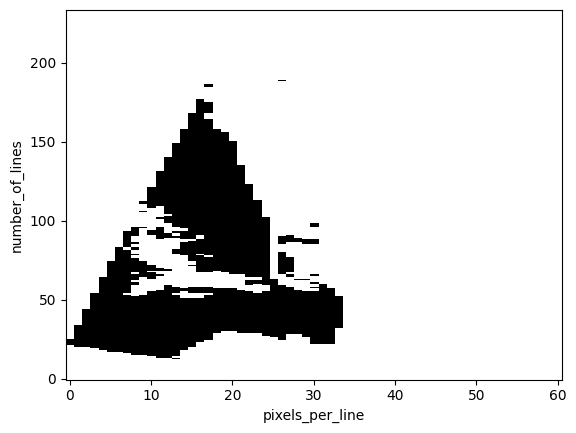

In [15]:
rrs_rgb.plot.imshow()